In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Image range falls outside",
    category=UserWarning,
)

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`MAD_Competition_2.ipynb`**!

:::

(mad-nb)=
# MAD Competition Usage

Maximum differentiation (MAD) competition comes [Wang, Z., & Simoncelli, E. P. (2008). Maximum differentiation (MAD) competition: A methodology for comparing computational models of perceptual discriminability. Journal of Vision](https://www.cns.nyu.edu/pub/lcv/wang08-preprint.pdf). In MAD Competition, the goal is to efficiently compare two competing perceptual metrics. Like the inputs for all synthesis methods in `plenoptic`, metrics operate on images and produce predictions related to perception. As originally conceived, the metrics in MAD competition are either similarity (e.g., SSIM) or distance (e.g., MSE) metrics: they take two images and return a scalar value that gives a perceptual similarity or distance. For distance metrics, the smaller this number is, the more perceptually similar the metric predicts they will be; for similarity metrics, the larger the number is, the more percpetually similar.

In `plenoptic`, a single instantiation of {class}`~plenoptic.synthesize.mad_competition.MADCompetition` synthesizes a single image, holding the {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.reference_metric` constant while either maximizing or minimizing {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.optimized_metric`, depending on the value of the {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.minmax` argument. A full set of MAD competition images consists of four images, maximizing and minimizing each of the two metrics. For each pair of images, one metric predicts they are perceptually identical, while the other metric predicts they are as dissimilar as possible. This set therefore allows us to efficiently compare the two metrics.

In the paper, these images are generated by manually computing the gradients, projecting one gradient out of the other, and repeating until convergence was reached. This doesn't work as well in the general case, so we instead optimize using the following objective function:

$$t L_1(x, \hat{x}) + \lambda_1 [L_2(x, x+\epsilon) - L_2(x, \hat{x})]^2 + \lambda_2 \mathcal{B}(\hat{x})$$

where:

- $t$ is 1 if {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.minmax` is `'min'` and -1 if it's `'max'`
- $L_1$ is {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.optimized_metric`
- $L_2$ is {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.reference_metric`
- $x$ is {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.image`
- $\hat{x}$ is {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.mad_image`
- $\epsilon$ is the initial noise
- $\mathcal{B}$ is the quadratic bound penalty
- $\lambda_1$ is {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.metric_tradeoff_lambda`
- $\lambda_2$ is {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.range_penalty_lambda`

That's the general idea, now let's explore how to use the {class}`~plenoptic.synthesize.mad_competition.MADCompetition` class for generating these images

In [2]:
import matplotlib.pyplot as plt
import torch

import plenoptic as po

# use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

%load_ext autoreload
%autoreload 2

## Basic usage

As with all our synthesis methods, we start by grabbing a target image and initializing our models.

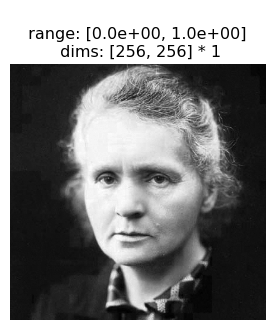

In [3]:
img = po.data.curie().to(DEVICE)
po.imshow(img);

To start, we'll demonstrate MAD competition as described in the paper, using two metrics: structural similarity index (SSIM, described in [Wang, Z., Bovik, A., Sheikh, H., & Simoncelli, E. (2004). Image quality assessment: from error visibility to structural similarity. IEEE Transactions
on Image Processing](https://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf)) and mean-squared error (MSE), implementations for both of which are in [plenoptic](metrics-api). We use the weighted version of SSIM described in the MAD Competition paper, hence the `weighted` argument passed to {func}`~plenoptic.synthesize.mad_competition.MADCompetition` expects [metrics](https://en.wikipedia.org/wiki/Metric_(mathematics)), which return 0 if and only if the two inputs are identical.

In [4]:
def model1(*args):
    return 1 - po.metric.ssim(*args, weighted=True, pad="reflect")


model2 = po.metric.mse

To initialize the object, we only need to specify the target image, the two metrics, and the target. To start, we will hold MSE constant, while minimizing SSIM.

Note that, as described in the beginning of this notebook, we synthesize these images by optimizing a tradeoff between the loss of these two metrics, weighted by the {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.metric_tradeoff_lambda`. If that argument is unset, we default to something we think is reasonable, but in practice, we often need to experiment and find the appropriate value, trying out different values until the fixed metric stays constant while the synthesis metric decreases or increases as desired.

In [5]:
mad = po.synth.MADCompetition(
    img,
    optimized_metric=model1,
    reference_metric=model2,
    minmax="min",
    metric_tradeoff_lambda=10000,
)
# optionally, set a different initial noise value:
mad.setup(0.04)

At the most basic, all we need to do is call the {func}`~plenoptic.synthesize.mad_competition.MADCompetition.synthesize` method. Let's do that and then view the outcome. There are several additional arguments to {func}`~plenoptic.synthesize.mad_competition.MADCompetition.synthesize` but none are required.

  0%|          | 0/200 [00:00<?, ?it/s]

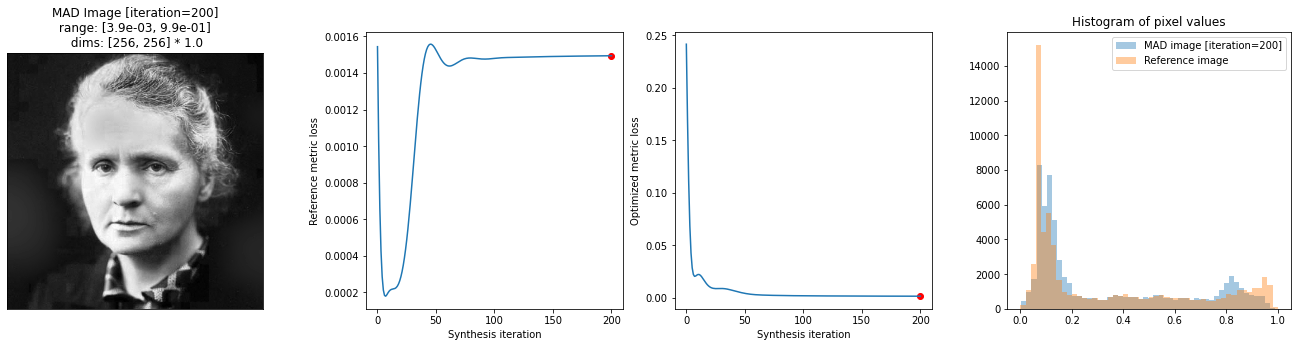

In [6]:
mad.synthesize(max_iter=200)
fig = po.synth.mad_competition.plot_synthesis_status(mad)

We can see from the loss plot that SSIM's loss has decreased, while MSE's, other than a brief dip in the beginning, is staying roughly constant.

As described in the opening paragraph, a full set of MAD competition synthesized images consists of four images. In order to create the other images, we must create a new instance of {class}`~plenoptic.synthesize.mad_competition.MADCompetition`. Let's do that for the other images now:

  0%|          | 0/200 [00:00<?, ?it/s]

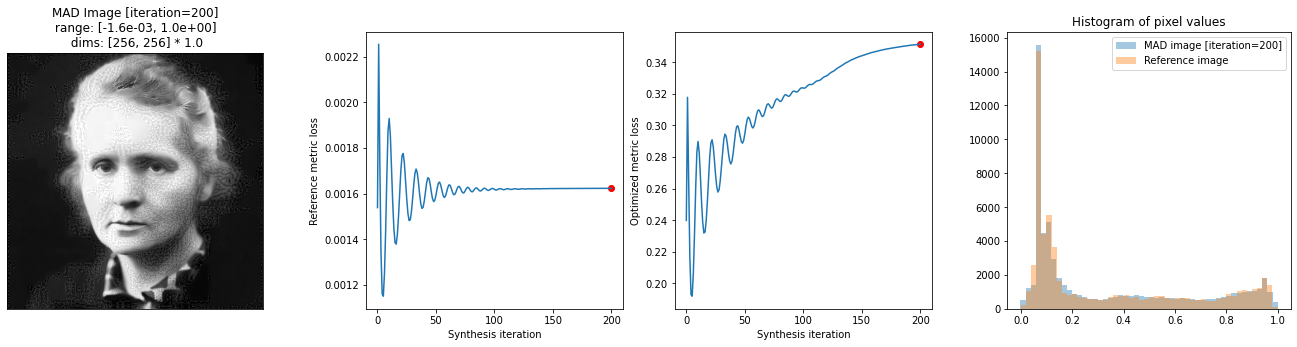

In [7]:
mad_ssim_max = po.synth.MADCompetition(
    img,
    optimized_metric=model1,
    reference_metric=model2,
    minmax="max",
    metric_tradeoff_lambda=1e6,
)
mad_ssim_max.setup(0.04)
mad_ssim_max.synthesize(max_iter=200)
fig = po.synth.mad_competition.plot_synthesis_status(mad_ssim_max)

We're making progress, but it doesn't look like `SSIM` has quite saturated. Let's see if we can make more progress!

To continue synthesis, we can simply call {func}`~plenoptic.synthesize.mad_competition.MADCompetition.synthesize` again, and we then pick up right where we left off.

  0%|          | 0/300 [00:00<?, ?it/s]

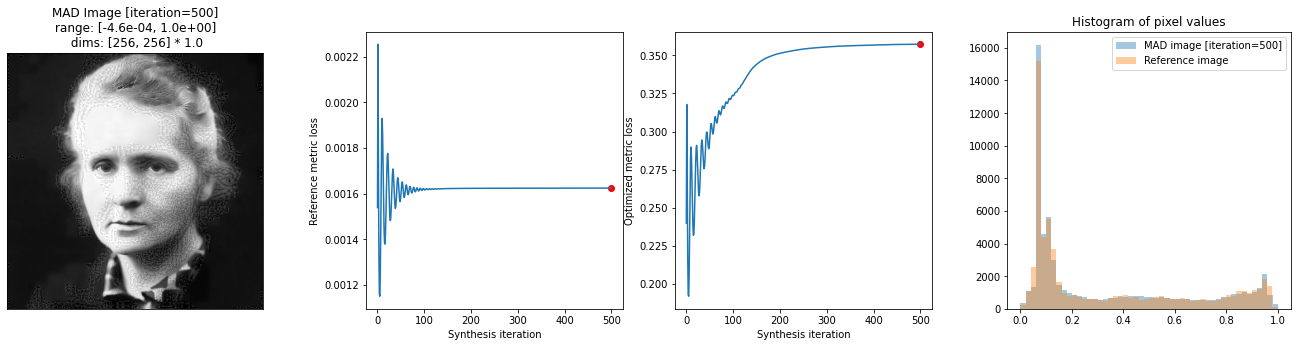

In [8]:
mad_ssim_max.synthesize(max_iter=300)
fig = po.synth.mad_competition.plot_synthesis_status(mad_ssim_max)

Next, let's hold SSIM constant while changing MSE. This will require changing the {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.metric_tradeoff_lambda`. We also set `stop_criterion` explicitly, to a smaller value, to allow the synthesis to continue longer.

In general, finding an appropriate value for {attr}`~plenoptic.synthesize.mad_competition.MADCompetition.metric_tradeoff_lambda` will require both some consideration on the part of the user and some testing of different values.

  0%|          | 0/400 [00:00<?, ?it/s]

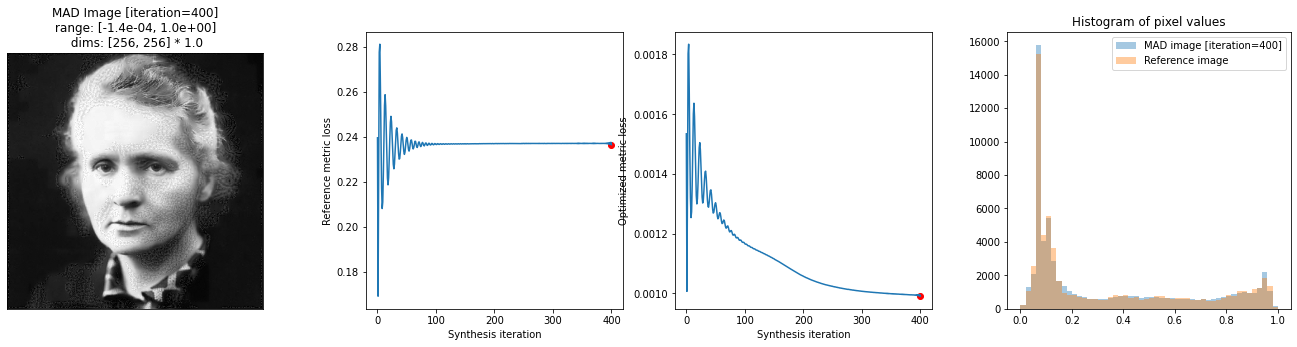

In [9]:
mad_mse_min = po.synth.MADCompetition(
    img,
    optimized_metric=model2,
    reference_metric=model1,
    minmax="min",
    metric_tradeoff_lambda=1,
)
mad_mse_min.setup(0.04)
mad_mse_min.synthesize(max_iter=400, stop_criterion=1e-6)
fig = po.synth.mad_competition.plot_synthesis_status(mad_mse_min)

  0%|          | 0/200 [00:00<?, ?it/s]

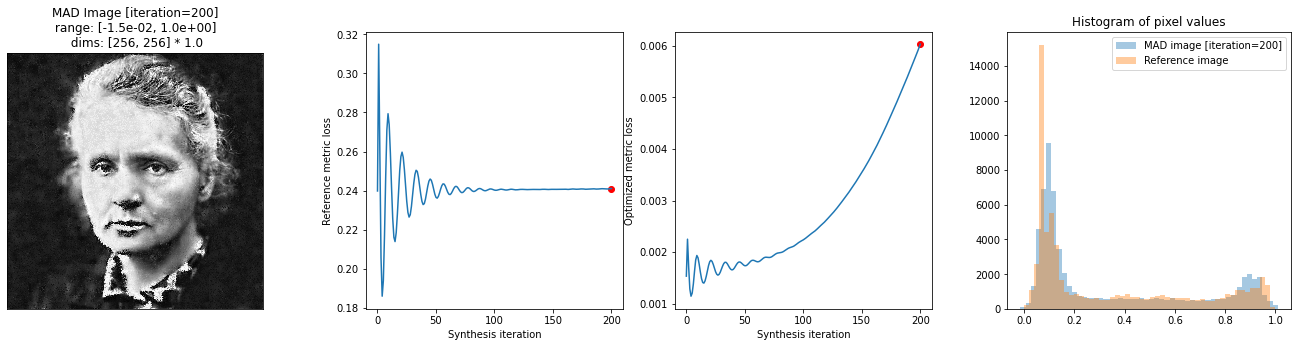

In [10]:
mad_mse_max = po.synth.MADCompetition(
    img,
    optimized_metric=model2,
    reference_metric=model1,
    minmax="max",
    metric_tradeoff_lambda=10,
)
mad_mse_max.setup(0.04)
mad_mse_max.synthesize(max_iter=200, stop_criterion=1e-6)
fig = po.synth.mad_competition.plot_synthesis_status(mad_mse_max)

The image above has increased the local contrast in different parts of the image, which SSIM generally doesn't care about but MSE does. For example, the collar, which in the original image is two different shades of gray, here is black and white. Similarly with the eyes, hair, and lips.

While above we displayed the synthesized image and the loss together, these are actually handled by two helper functions, {func}`~plenoptic.synthesize.mad_competition.display_mad_image` and {func}`~plenoptic.synthesize.mad_competition.plot_loss`, which can be called separately as axes-level functions. They have additional arguments that may be worth playing around with:

<Axes: xlabel='Synthesis iteration', ylabel='Optimized metric loss'>

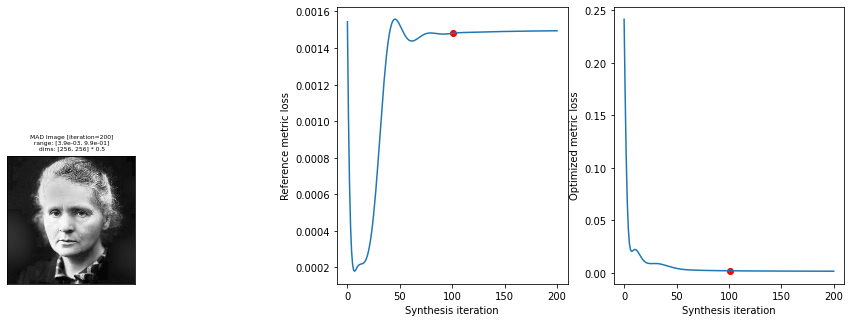

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"width_ratios": [1, 2]})
po.synth.mad_competition.display_mad_image(mad, ax=axes[0], zoom=0.5)
po.synth.mad_competition.plot_loss(mad, axes=axes[1], iteration=-100)

We also provide helper functions to plot a full set of MAD images together, either displaying all their synthesized images or their losses (note that we're calling our metric `SDSIM` because it's now the structural *dis*-similarity):

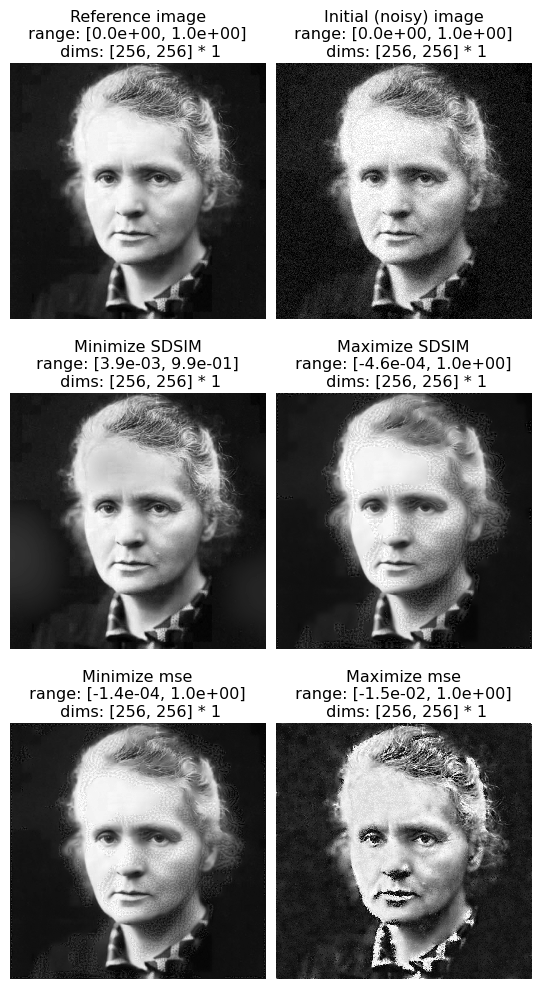

In [12]:
po.synth.mad_competition.display_mad_image_all(
    mad, mad_mse_min, mad_ssim_max, mad_mse_max, "SDSIM"
);

The top row shows the reference and initial images, our picture of Marie Curie and that same image plus some normally-distributed noise. The next row of images has the same MSE as the right image in the top row (when compared against the reference image), but different SDSIM values. The left image has the lowest SDSIM and is thus considered the best image, while the right image has the highest SDSIM and is thus considered the worst. The next row of images has the same SDSIM as the right image in the top, but different MSE values. The left has the lowest MSE and is thus considered the best, while the right has highest MSE and is thus considered the worst.

So MSE considers the rightmost image in the top row and the images in the second row to be approximately equivalent in quality, while SDSIM considers that rightmost image int he top row and the last row to be equivalent.

From the following plot, we can see that we generally manage to hold the fixed metric constant (orange lines in the right plot, blue lines in the left) while changing the target metric.

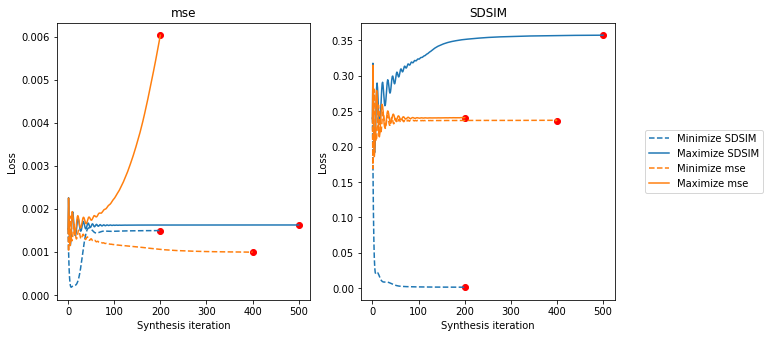

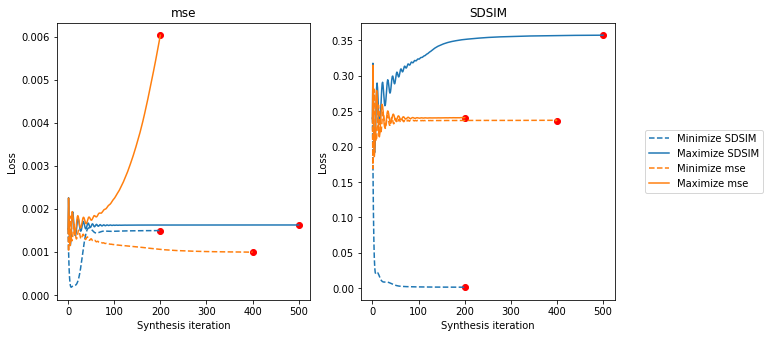

In [13]:
po.synth.mad_competition.plot_loss_all(
    mad, mad_mse_min, mad_ssim_max, mad_mse_max, "SDSIM"
)